<img src="../data/AI_Lab_logo.jpg" width="100" align="right"/>

# 고해상도 위성영상(Sentinel-2)과 Machine Learning을 활용한 저수지 녹조모니터링

- K-water연구원 AI연구센터 
- 최영돈 책임연구원(choiyd1115@kwater.or.kr), 정지영 책임위원(jyjung@kwater.or.kr), 김성훈 AI연구센터장(sunghoonkim@kwater.or.kr)

## 1. 추진배경 및 목적

- 기후변화에 따른 기온의 지속적인 상승으로 수체의 녹조증식이 증대


- 또한, 매년 저수지에 발생하는 녹조는 시기별 기상여건이나 수체흐름에 따라 발생농도나 위치가 변화됨에 따라


- 금번 연구에서는 Sentinel-2 위성과 Machine Learning기술을 활용하여 점단위 모니터링에서 광범위하게 발생하는 녹조를 효율적으로 관리할 수 있는 광역적 모니터링 및 분석 방법론을 제시하고자 함

## 2. 주요 내용

- 영주댐은 낙동강 내성천 상류에 위치한 다목적댐으로 2016년 12월 조성되어 '19년 하반기부터 댐안정성 검사를 위하여 담수를 시작함


- 담수이후 여름철 공간적인 녹조발생 분포를 모니터링하기 위해 2020년 K-water연구원(수자원환경연구소)에서는 "선박부착형 센서를 이용해 녹조(Green Algae, Bluegreen, Diatoms와 Cryptophyta)를 측정하고, 동일시간대의 Sentinel-2 위성 분광특성값을 활용하여 Machine Learning모델을 구축, 광역적 녹조발생 특성을 모니터링하기 위한 연구 시행


- 선박부착형 센서를 활용한 모니터링 공간적 범위 및 정점조사 지점도
  - 면단위조사: 영주댐저수지, 유사조절지
  - 정점  조사: 영주댐 호내 5개, 유사조절지 2개 지점

<img src="../data/유역이미지.png" width="500">

- Sentinel-2 위성 및 분광특성 (시간해상도: 5일주기)
  - 면단위조사: 영주댐저수지, 유사조절지
  - 정점  조사: 영주댐 호내 5개, 유사조절지 2개 지점

<tr>
<td> <img src="../data/sentinel.jpeg" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="../data/band.png" alt="Drawing" style="width: 400px;"/> </td>
</tr>

## 3. 데이터 수집

- (선박측정) '20년 2~9월까지 선박부착형 센서를 활용, 조류강별 Chl-a 모니터링 자료 확보
  - 측정장비: 수중형 연속조류측정기 (FluoroProbe)

In [ ]:
import geopandas
import numpy as np
import folium

yjd_gdf = geopandas.read_file('../data/algae_obs.shp')
yjd_gdf['lon'] = yjd_gdf.geometry.apply(lambda p: p.x)
yjd_gdf['lat'] = yjd_gdf.geometry.apply(lambda p: p.y)

lat = yjd_gdf['lat'].mean()
lon = yjd_gdf['lon'].mean()

m = folium.Map([lat,lon],zoom_start=13)

for i in yjd_gdf.index:
    sub_lat = yjd_gdf.loc[i,'lat']
    sub_lon = yjd_gdf.loc[i,'lon']

    if (np.isnan(sub_lat) == False) & (np.isnan(sub_lat) == False) :
        folium.CircleMarker([sub_lat,sub_lon], icon_size=(1,1), radius=2, color="crimson", fill=True).add_to(m)
m

  - 구름 등 날씨를 고려하여 활용가능성 일자 선정 (기상값은 영주지점 일평균 자료 활용)
| 관측일 | 운량, 1/10 | 기온 (섭씨) |
| :- | -: | :-: |
| '20.02.19 | 6.6| 1.0
| '20.08.20 | 2.1 | 26.0
| '20.08.25 | 4.1 | 26.7
| '20.09.14 | 5.6 | 19.4


- (Sentinel-2) 선박측정시 위경도값으로 위성과 밴드값 매칭
| 관측일 | '20.02.19 | '20.08.20 | '20.08.25 | '20.09.14 | 합계 |
| :- | -: |  -: | -: | -: |:-: |
| 자료수 | 2,600| 2,634 | 2,057 | 14 | 7,291

## 4. 분석절차

1. Import **pyalgae_ai** Python 라이브러리
2. 입력자료를 Pandas로 불러와서 입력자료(Sentinel-2)와 Label자료(Algae Observation Data)를 구분 및 분석
3. 위성영상에서 분석할 **열 (Sentinel의 밴드, 온도, 운량 조합)**의 조합을 선택
4. algae_monitor 함수를 이용, Machine Learning 실행
5. Maching Learning 분석결과 확인
6. 결과값에 대한 Performance Test 실행
7. 모델 튜닝 (Performance결과에 따라 모델의 적정 파라미터 재산정을 위한 절차)
8. 입력(Sentinel-2)와 결과(algae) 관계 Graph 생성
9. Training을 통해 개발된 모델을 Pickle(pkl) 파일로 저장 및 활용

### 4-1 Import Python Libraries

- 본 pyalgae_ai python 라이브러리는 Sentinel-2 위성과 관측녹조자료의 Machine Learning 분석을 위해 K-water AI연구센터에서 개발

In [3]:
import pyalgae_ai as AI
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 4.2 Sentinel-2와 Algae Observation 자료의 구분 및 분석

#### Sentinel-2 자료와 Algae 관측자료가 정리된 CSV 파일 지정 (Directory가 다를 경우, Directory도 포함필요)

<img src="../data/입력포맷.png" width="800">

In [4]:
raw_obs = "../data/20220224_sentinels_and_algae_obs.csv"

#### Machine Learning 클래스를 활용하여 algae Object 생성

 - Machine Learning 클래스의 첫번째 파라미터는 CSV 파일을 지정, 
 
 - 두번째 파라미터는 G열(6번) ~ T열(20번)까지 input_sentinel(입력값), B열(1번) ~ F열(6번)까지 label_algae(라벨)로 지정

In [5]:
algae = AI.Machine_Learning(raw_obs, [1,6,20])
input_sentinel, label_algae = algae.preprocessing()

####  < 입력값 확인 >

In [6]:
input_sentinel

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,AT,CLOUD
0,0.0061,0.0131,0.0121,0.0080,0.0081,0.0056,0.0087,0.0058,0.0051,0.0069,0.0111,0.0094,1.0,6.6
1,0.0051,0.0180,0.0160,0.0112,0.0106,0.0087,0.0095,0.0098,0.0083,0.0052,0.0109,0.0080,1.0,6.6
2,0.0238,0.0125,0.0210,0.0205,0.0413,0.0443,0.0478,0.0242,0.0363,0.0333,0.0454,0.0479,1.0,6.6
3,0.0053,0.0137,0.0121,0.0092,0.0068,0.0065,0.0058,0.0077,0.0081,0.0059,0.0095,0.0073,1.0,6.6
4,0.0072,0.0181,0.0173,0.0117,0.0104,0.0065,0.0119,0.0104,0.0098,0.0080,0.0103,0.0110,1.0,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,0.0261,0.0293,0.0413,0.0247,0.0349,0.0262,0.0292,0.0240,0.0223,0.0167,0.0080,0.0035,26.7,4.1
7301,0.0270,0.0306,0.0458,0.0239,0.0502,0.0334,0.0366,0.0277,0.0254,0.0205,0.0093,0.0055,26.7,4.1
7302,0.0270,0.0289,0.0485,0.0259,0.0551,0.0355,0.0383,0.0272,0.0261,0.0205,0.0089,0.0060,26.7,4.1
7303,0.0304,0.0304,0.0364,0.0244,0.0365,0.0314,0.0345,0.0274,0.0291,0.0128,0.0131,0.0065,26.7,4.1


####  < 라벨값 확인 >

In [7]:
label_algae

,total_chla,Green_Algae,Bluegreen,Diatoms,Cryptophyta
0,0.00,0.0,0.00,0.00,0.00
1,0.27,0.0,0.27,0.00,0.00
2,0.64,0.0,0.00,0.64,0.00
3,0.75,0.0,0.75,0.00,0.00
4,0.77,0.0,0.04,0.00,0.72
...,...,...,...,...,...
7300,166.13,0.0,138.46,0.00,27.67
7301,168.90,0.0,138.33,0.00,30.57
7302,175.06,0.0,144.44,0.00,30.62
7303,191.14,0.0,146.90,0.00,44.23


#### Sentinel-2와 Algae Observation 상관관계 분석

In [21]:
pair_plot1 = pd.concat([label_algae, input_sentinel[list(input_sentinel)[0:3]]], axis=1)
pair_plot2 = pd.concat([label_algae, input_sentinel[list(input_sentinel)[3:6]]], axis=1)
pair_plot3 = pd.concat([label_algae, input_sentinel[list(input_sentinel)[6:9]]], axis=1)
pair_plot4 = pd.concat([label_algae, input_sentinel[list(input_sentinel)[9:12]]], axis=1)

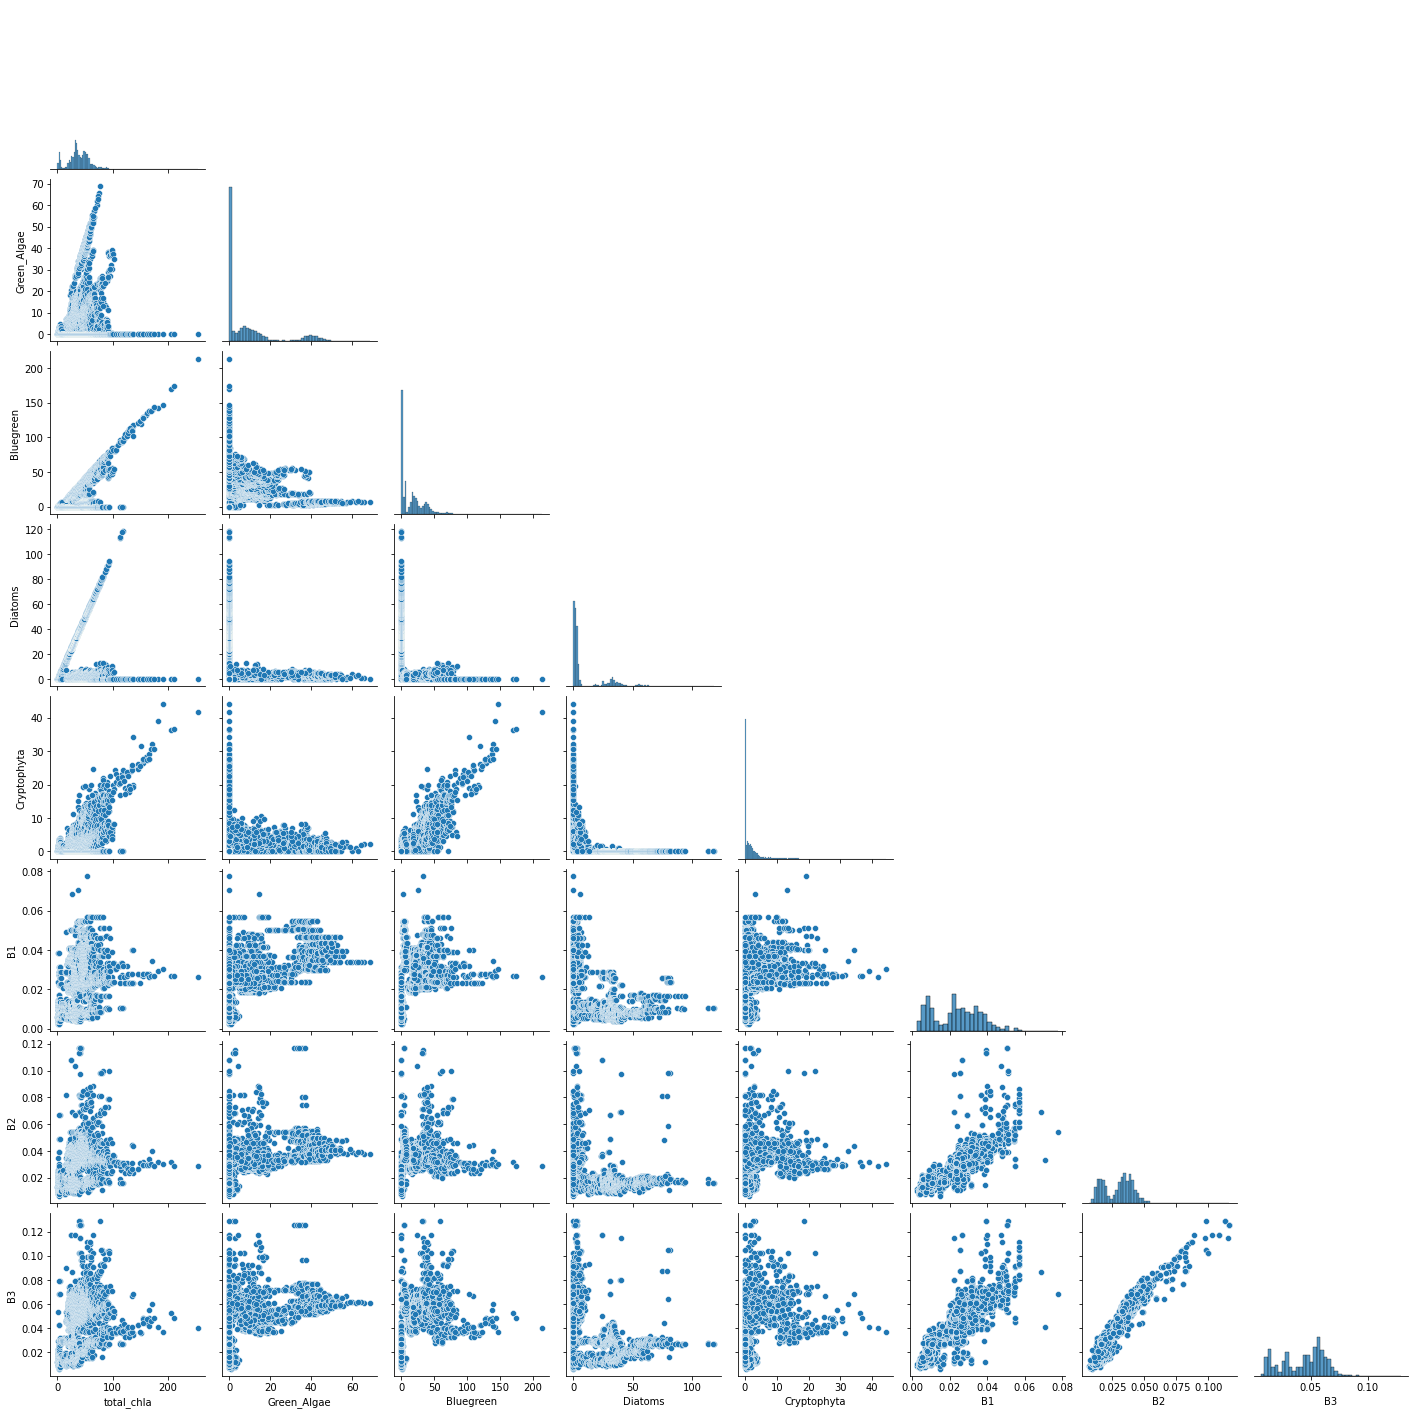

In [20]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.pairplot(pair_plot1, corner=True)
plt.show()

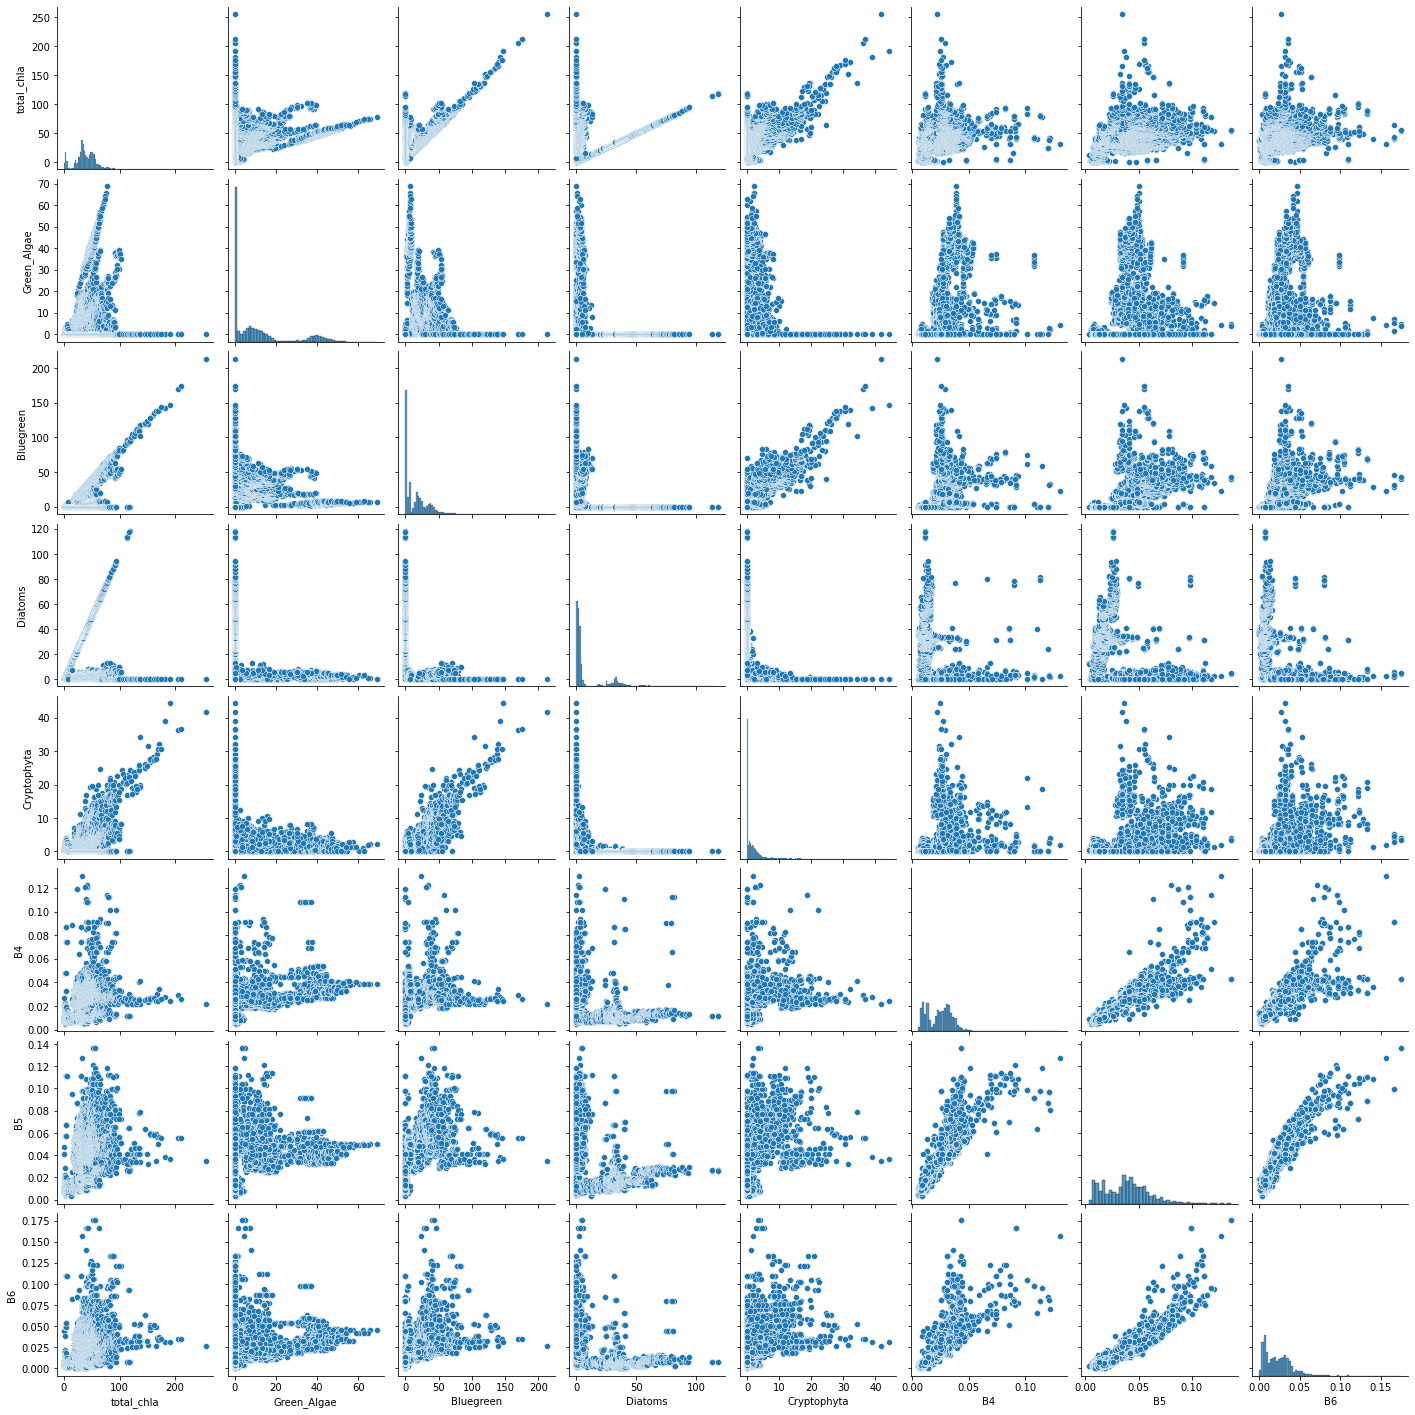

In [22]:
sns.pairplot(pair_plot2, corner=True)
plt.show()

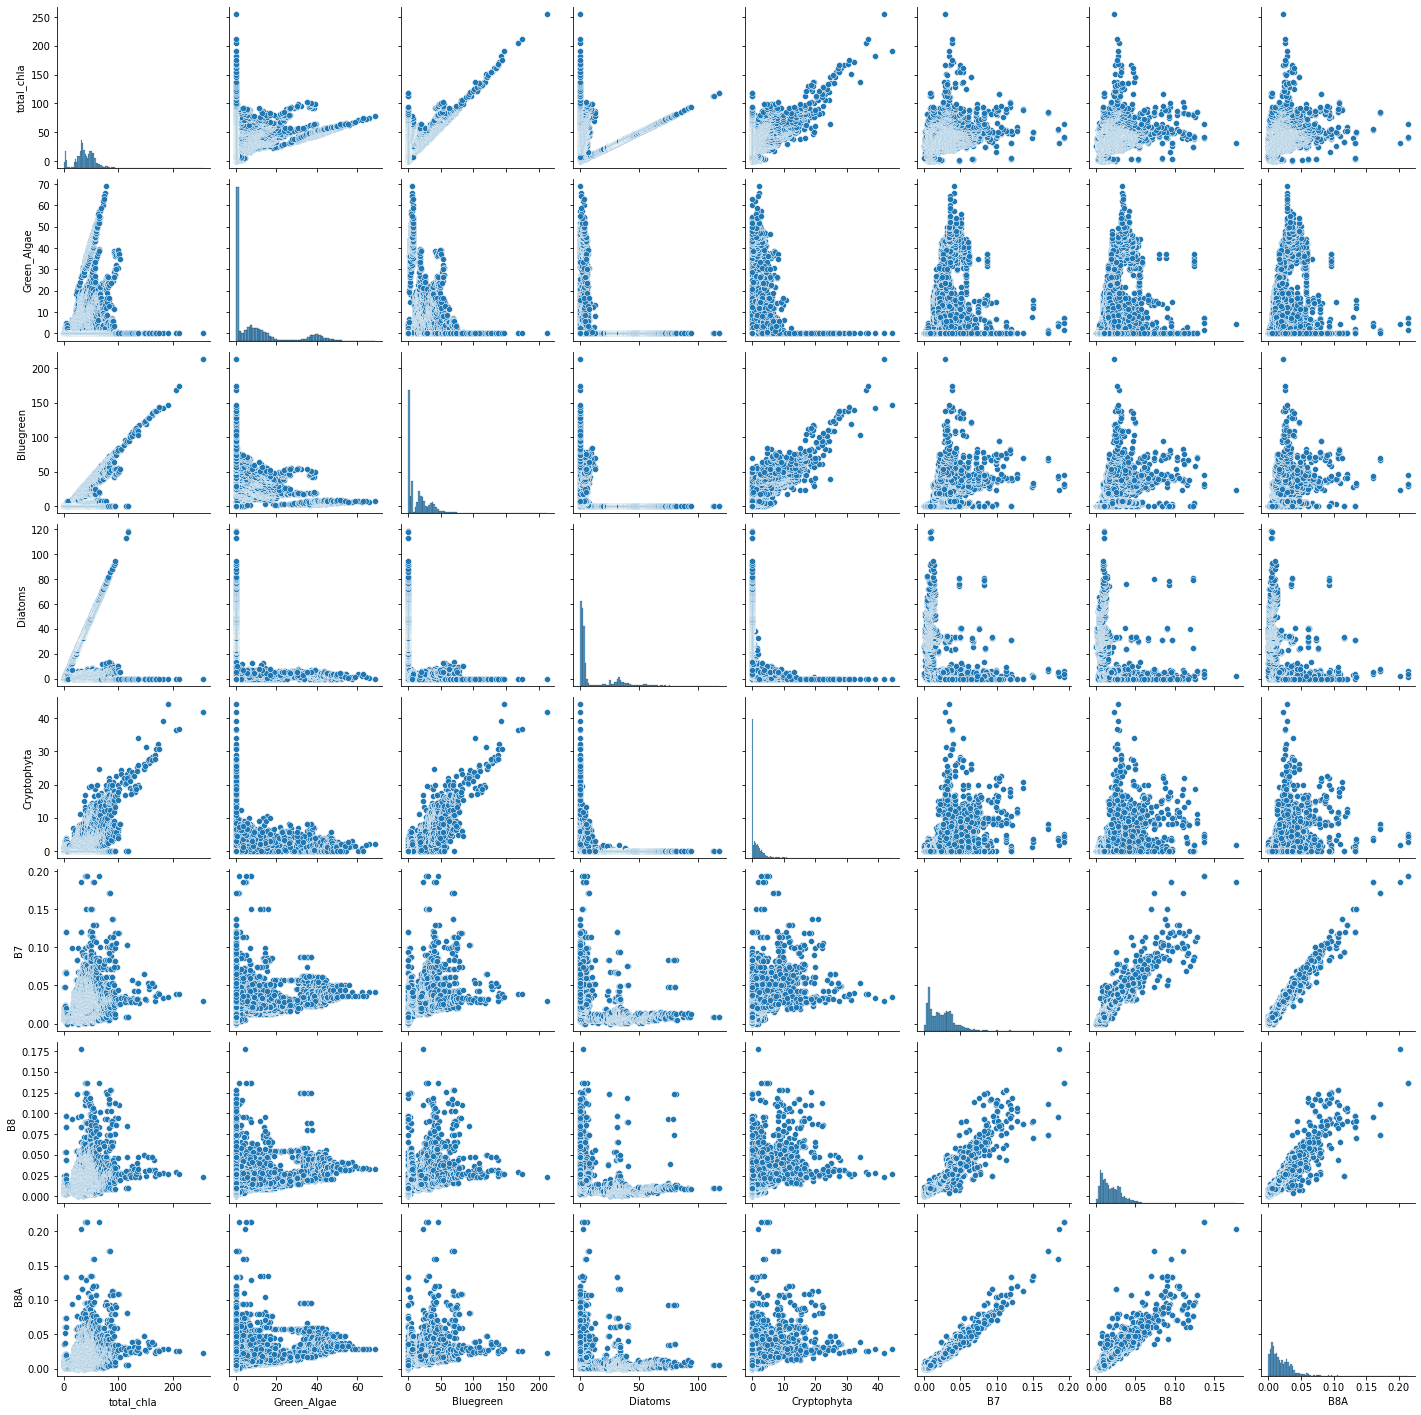

In [23]:
sns.pairplot(pair_plot3, corner=True)
plt.show()

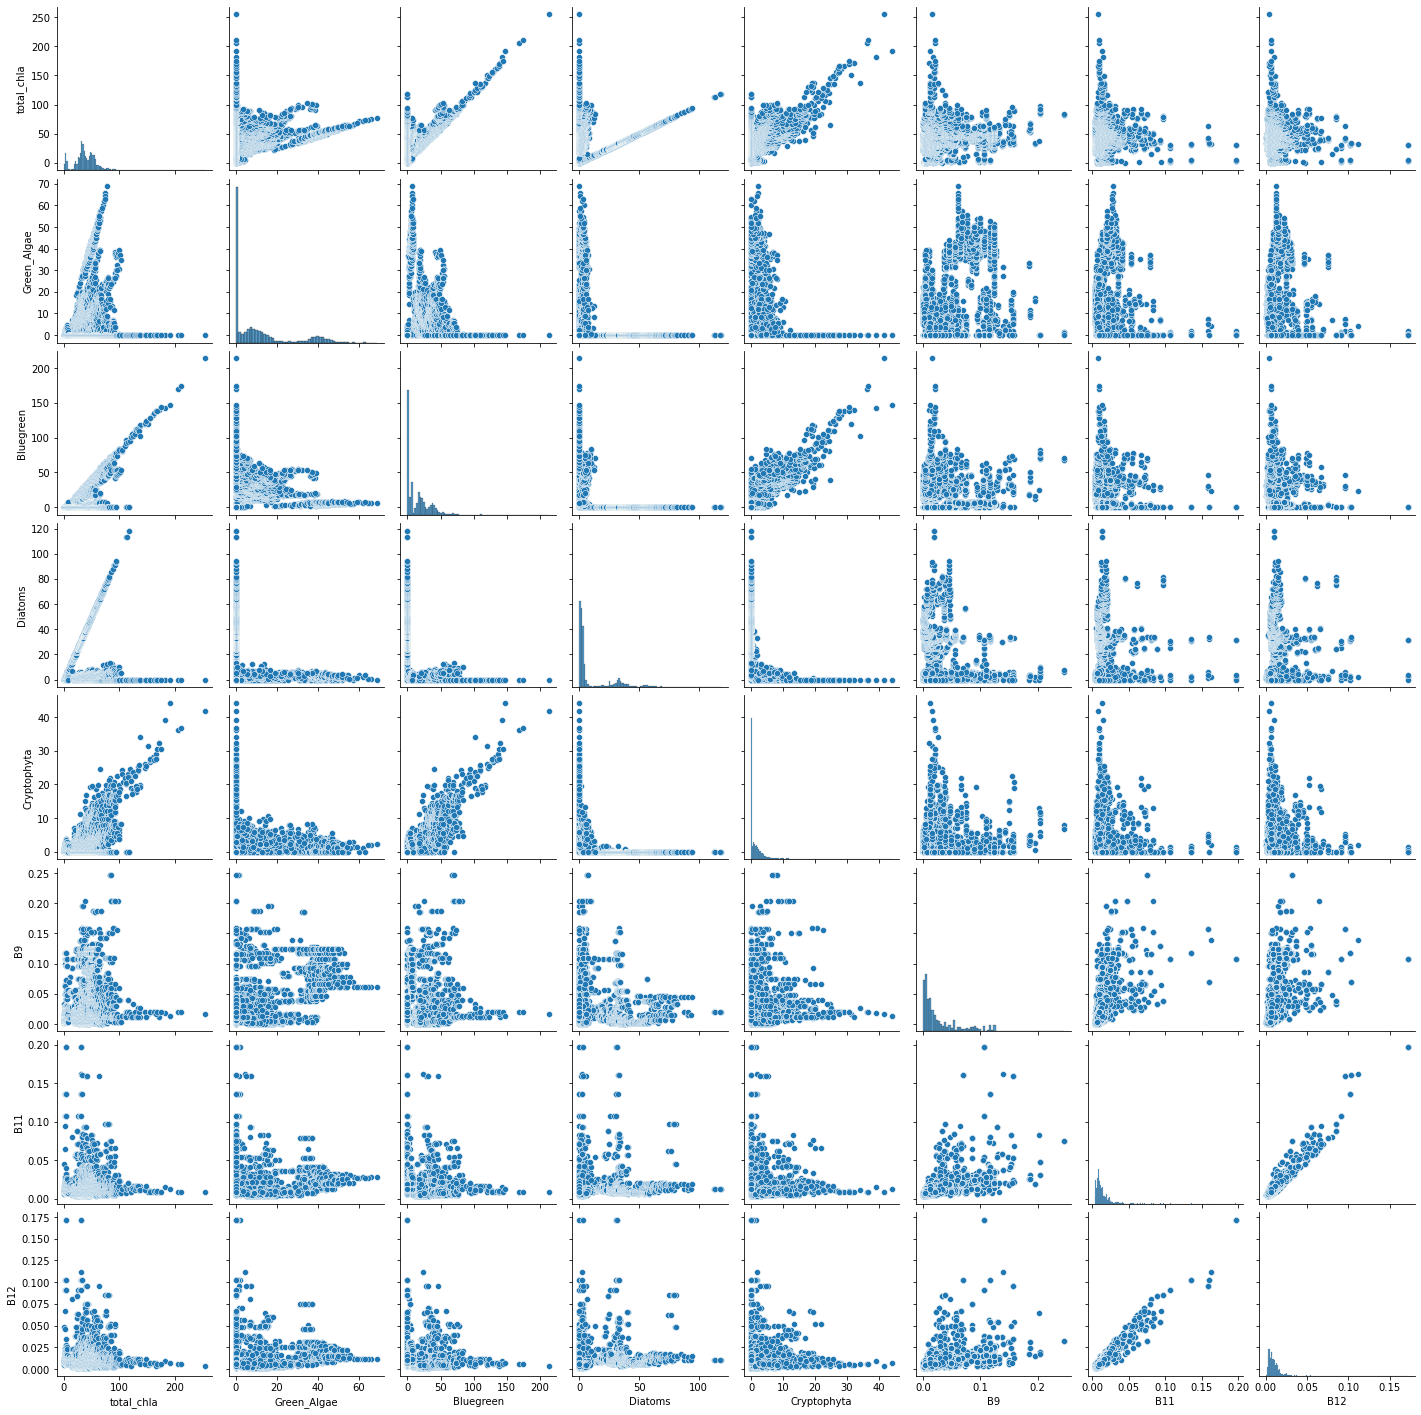

In [24]:
sns.pairplot(pair_plot4, corner=True)
plt.show()

### 4.3 위성영상에서 분석할 **열 (Sentinel의 밴드, 온도, 운량 조합)**의 조합을 선택

- 입력값의 전체 Datasets "['B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12 AT CLOUD']"이 가장 높은 상관관계를 보여줌


- 필요시 List의 형태로 아래와 같이 조합을 추가 가능 (아래의 예는 3개의 조합을 선택한 것임)

In [6]:
select_columns = [['B1 B2 B3'], ['B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12 AT CLOUD'], ['B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12']]

### 4.4 algae_monitor 함수를 이용, Machine Learning 실행

- input_sentinel, label_algae, select_columns은 앞에서 얻은 값을 입력


- model_list는 **"RF"** (Random Forest Regression Algorithm), **"GBR"** (Gradient Boosting Regression Algorithm), **"XGB"** XGBoosting Algorithm 중 선택가능, **본 예제에서는 Random Forest Regression Algorithm 선택**


- Traning Data의 크기는 전체데이터의 0.8로 지정, n_estimator=100로 지정(RF의 가지수 지정), random_state=42로 지정(난수발생 고정)


- 3개 조합의 Training시행시 약 40초가 소요됨 (1개 조합에 약 13~14초 소요)

In [7]:
%%time
results = AI.algae_monitor(input_sentinel, label_algae, select_columns, model_list=["RF"], trainSize_rate=0.8, n_estimators=200, random_state=42)

parameter : B1 B2 B3
parameter : B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12 AT CLOUD
parameter : B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12
Wall time: 1min 47s


### 4.5 Maching Learning 결과값 확인

- 결과값은 총 15개이며, **[5개의 목표값: 1) total_chla,	2) Green_Algae,	3) Bluegreen,	4) Diatoms,	5) Cryptophyta]** X **[3개의 입력조합 1) ['B1 B2 B3'], 2) ['B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12 AT CLOUD'], 3) ['B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12']** 의 갯수임


- results[0] : ['B1 B2 B3'] 입력조합의 "total_chla" 분석결과, results[1] : ['B1 B2 B3'] 입력조합의 "Green_Algae" 분석결과


- results[2] : ['B1 B2 B3'] 입력조합의 "Bluegreen" 분석결과, results[3] : ['B1 B2 B3'] 입력조합의 "Diatoms" 분석결과


- results[4] : ['B1 B2 B3'] 입력조합의 "Cryptophyta" 분석결과


- 그 다음부터 순서대로 results[5] : ['B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12 AT CLOUD'] 입력조합의 "total_chla" 분석결과 임


- 이와 같이 분석결과는 results[0] ~ results[14]까지 얻을 수 있음


- 그리고 results[Num]이후 각 결과값은 "model", "X_train", "Y_train", "X_test", "Y_test", "Y_train_predict", "Y_test_predict" 7개의 값으로 구성되어 있으며, 각각 results[Num]이후에 results[Num][0]~results[Num][6]으로 값을 얻을 수 있음

In [8]:
print(len(results), len(results[0]))

15 7


- ['B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12 AT CLOUD']의 model 확인

In [9]:
results[1][0]

RandomForestRegressor(n_estimators=200, random_state=42)

- ['B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12 AT CLOUD']의 "Y_test_predict" 확인

In [10]:
results[1][6]

array([19.95503917,  0.        ,  0.        , ...,  1.3575719 ,
        0.071575  ,  1.3575719 ])

### 4.6 결과값에 대한 Performance Test 실행

- 본 Performance Test에서는 "R2", "MSE", "MAE", "RMSE", "NSE", "KGE"가 이용가능하며 performance_test 함수에 입력하면 됨

In [11]:
# 전체 결과 확인
for i in range(len(results)):
    score_train, score_test = AI.performance_test("NSE", results[i])
    f_result = '"{}" and "{}"의 결과: score_train={}, score_test={}'.format(' '.join(list(results[i][1])), results[i][2].name, score_train, score_test)
    print(f_result)

"B1 B2 B3" and "total_chla"의 결과: score_train=[0.94652304], score_test=[-0.19846385]
"B1 B2 B3" and "Green_Algae"의 결과: score_train=[0.98311322], score_test=[0.84297316]
"B1 B2 B3" and "Bluegreen"의 결과: score_train=[0.96880172], score_test=[0.6875657]
"B1 B2 B3" and "Diatoms"의 결과: score_train=[0.9761825], score_test=[0.87456998]
"B1 B2 B3" and "Cryptophyta"의 결과: score_train=[0.90289171], score_test=[0.293623]
"B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12 AT CLOUD" and "total_chla"의 결과: score_train=[0.97335108], score_test=[0.54433518]
"B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12 AT CLOUD" and "Green_Algae"의 결과: score_train=[0.99438414], score_test=[0.96677871]
"B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12 AT CLOUD" and "Bluegreen"의 결과: score_train=[0.98363935], score_test=[0.9142226]
"B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12 AT CLOUD" and "Diatoms"의 결과: score_train=[0.99183125], score_test=[0.97046547]
"B1 B2 B3 B4 B5 B6 B7 B8 B8A B9 B11 B12 AT CLOUD" and "Cryptophyta"의 결과: score_train=[0.94414087], score_t

In [12]:
# 가장 좋은 결과
score_train, score_test = AI.performance_test("NSE", results[6])
score_train, score_test

(array([0.99438414]), array([0.96677871]))

### 4.7 모델 튜닝

- Performance Test결과가 낮게 나와서 파라미터의 수정이 필요한 경우, 새로운 데이터 및 유사한 자료 포맷의 자료를 본 머신러닝 코드에 적용시 적절한 n_estimators와 max_features값 등의 적용이 필요할 때 모델 튜닝 시행


- 본 방법에서는 Grid Search CV 이용

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
param_grid = [
    {'n_estimators':[50, 100, 200], 'max_features':[2, 4, 6, 8]},
    {'bootstrap': [False]}
]

In [15]:
grid_search = GridSearchCV(results[1][0], param_grid, cv=5, 
                           scoring='r2',
                          return_train_score=True)

In [16]:
%%time
grid_search.fit(results[1][1], results[1][2])

C:\ProgramData\Anaconda3\envs\estuary\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 65.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\estuary\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\envs\estuary\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "C:\ProgramData\Anaconda3\envs\estuary\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
 

Wall time: 28.7 s


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(n_estimators=200, random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [50, 100, 200]},
                         {'bootstrap': [False]}],
             return_train_score=True, scoring='r2')

In [17]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 200}

### 4.8 입력(Sentinel-2)와 결과(algae) 관계 Graph 생성

- Performance Test결과에 따라 세번째 파라미터를 "R2", "MSE", "MAE", "RMSE", "NSE", "KGE"와 같이 지정하여 그래프생성

In [18]:
Y_test = results[6][4]
Y_test_predict = results[6][6]

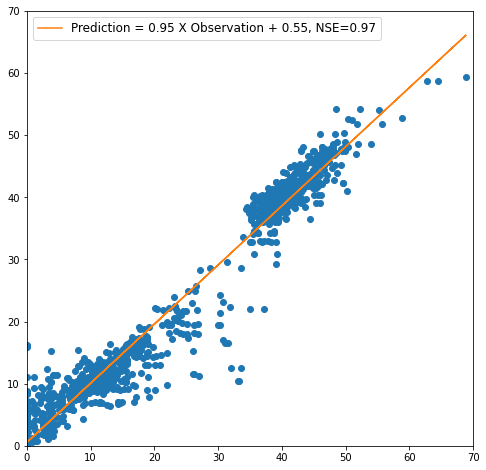

In [19]:
AI.plotting.linear_regression(Y_test, Y_test_predict, "NSE", score_test[0])

### 4.9 Training을 통해 개발된 모델을 Pickle(pkl) 파일로 저장 및 활용

-Training된 모델을 활용하여 향후 입력값(위성관측자료)에 따른 녹조를 분석할 경우 모델을 저장한 후 별도의 Training 없이 모델을 불러서 사용가능

In [20]:
import joblib
from hydroeval import evaluator, nse, kge

In [21]:
joblib.dump(results[6][0], "rf_model.pkl")

['rf_model.pkl']

In [22]:
rf_model_loaded = joblib.load("rf_model.pkl")

In [23]:
Y_test_predict_loaded = rf_model_loaded.predict(results[6][3])
Y_test_predict_loaded

array([2.05651999e+01, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 7.55000000e-03, 0.00000000e+00])

In [24]:
nse_score_test_loaded = evaluator(nse, results[1][4], Y_test_predict_loaded, axis=1)
nse_score_test_loaded[0]

0.9667787113921852

## 5. 향후 계획


### 5.1 Sentinel-2 자료의 Online 취득 및 댐별 관측지점자료 취득 코드 개발

In [ ]:
# connect to the API
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date

api = SentinelAPI('lukechoi76', 'bins0418', 'https://apihub.copernicus.eu/apihub')

myshpfile = geopandas.read_file('YD_Dam_Rect.shp')
myshpfile.to_file('YD_Dam_Rect.geojson', driver='GeoJSON')

# search by polygon, time, and SciHub query keywords
footprint = geojson_to_wkt(read_geojson('YD_Dam_Rect.geojson'))
products = api.query(footprint,
                     date=('20151219', date(2015, 12, 29)),
                     platformname='Sentinel-2')

# convert to Pandas DataFrame
products_df = api.to_dataframe(products)

# sort and limit to first 5 sorted products
products_df_sorted = products_df.sort_values(['cloudcoverpercentage', 'ingestiondate'], ascending=[True, True])
products_df_sorted = products_df_sorted.head(5)
products_df_sorted

### 5.2 Web App개발을 통한 UI기반 분석환경 제공
  
### 5.3 타 댐 적용방안 마련